# 基于MindSpore的图像识别全流程代码实战

本实验将会利用一个开源数据集来帮助大家学习如何构建自己的图像识别模型。本实验会使用MindSpore来构建图像识别模型，实现花卉识别功能。

## 1、实验目的

- 掌握如何使用MindSpore进行ResNet50神经网络模型的开发。
- 了解如何使用MindSpore进行花卉图片分类任务的训练。
- 了解如何使用MindSpore进行花卉图片分类任务的测试。

## 2、ResNet模型介绍

ResNet50网络是2015年由微软实验室的何恺明提出，获得ILSVRC2015图像分类竞赛第一名。在ResNet网络提出之前，传统的卷积神经网络都是将一系列的卷积层和池化层堆叠得到的，但当网络堆叠到一定深度时，就会出现退化问题。下图是在CIFAR-10数据集上使用56层网络与20层网络训练误差和测试误差图，由图中数据可以看出，56层网络比20层网络训练误差和测试误差更大，随着网络的加深，其误差并没有如预想的一样减小。

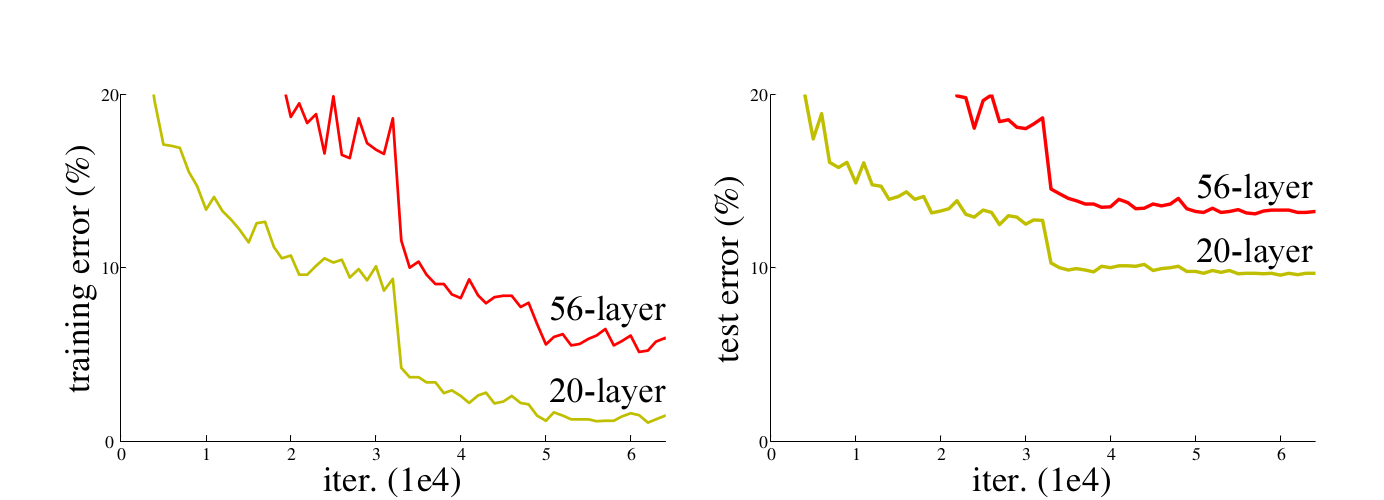

ResNet网络提出了残差网络结构(Residual Network)来减轻退化问题，使用ResNet网络可以实现搭建较深的网络结构（突破1000层）。论文中使用ResNet网络在CIFAR-10数据集上的训练误差与测试误差图如下图所示，图中虚线表示训练误差，实线表示测试误差。由图中数据可以看出，ResNet网络层数越深，其训练误差和测试误差越小。

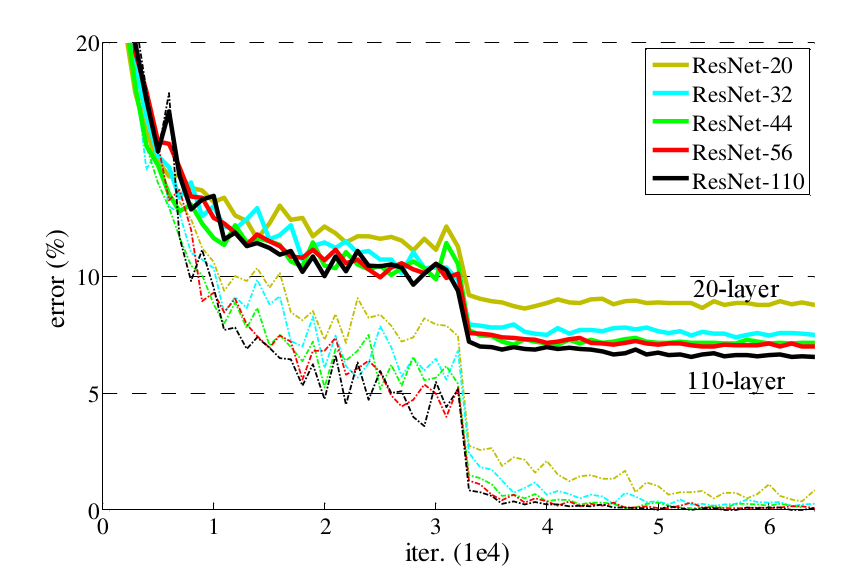

了解ResNet网络更多详细内容，参见[ResNet论文](https://arxiv.org/pdf/1512.03385.pdf)。

## 3、实验环境

本案例支持win_x86和Linux系统，CPU/GPU/Ascend均可运行。

如果在本地运行此实验，请参考《MindSpore环境搭建实验手册》在本地安装MindSpore。

## 4、数据处理

### 4.1数据准备

该数据集是开源数据集，总共包括5种花的类型：分别是daisy（雏菊，633张），dandelion（蒲公英，898张），roses（玫瑰，641张），sunflowers（向日葵，699张），tulips（郁金香，799张），保存在5个文件夹当中，总共3670张，大小大概在230M左右。为了在模型部署上线之后进行测试，数据集在这里分成了flower_train和flower_test两部分。

In [1]:
from download import download

# 下载flower_photos训练数据集
url = "https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/flower_photos_train.zip"
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|████████████████████████████| 227M/227M [02:54<00:00, 1.30MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


In [2]:
from download import download

# 下载flower_photos验证数据集
url = "https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/flower_photos_test.zip"
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 3.01M/3.01M [00:02<00:00, 1.16MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


## 4.2数据加载

###### 导入相应的模块

os模块主要用于处理文件和目录，比如：获取当前目录下文件，删除制定文件，改变目录，查看文件大小等；MindSpore是目前业界最流行的深度学习框架，在图像，语音，文本，目标检测等领域都有深入的应用，也是该实验的核心，主要用于定义占位符，定义变量，创建卷积神经网络模型；numpy是一个基于python的科学计算包，在该实验中主要用来处理数值运算。

In [1]:
# 字典访问，用来存储超参数
from easydict import EasyDict as edict
# os模块主要用于处理文件和目录
import os
# 科学计算库
import numpy as np
# 绘图库
import matplotlib.pyplot as plt

# MindSpore库
import mindspore
# 导入神经网络模块、环境设置模块、张量、模型导出、ops、模型加载等常见算子操作
from mindspore import nn, Tensor, export, ops, load_checkpoint, load_param_into_net
# 动量优化器
from mindspore.nn import Momentum
# 数据集处理模块
import mindspore.dataset as ds
# 图像增强模块
from mindspore.dataset import vision
# 模型编译及模型保存设置
from mindspore.train import Model, ModelCheckpoint, CheckpointConfig, LossMonitor
# 损失值平滑处理
from mindspore.amp import FixedLossScaleManager

# 设置MindSpore的执行模式和设备
mindspore.set_context(mode=mindspore.GRAPH_MODE, device_target="CPU")

###### 定义变量

In [2]:
cfg = edict({
    'data_path': 'flower_photos_train',   #训练数据集，如果是zip文件需要解压
    'test_path':'flower_photos_test',     #测试数据集，如果是zip文件需要解压
    'data_size': 3616,
    'HEIGHT': 224,     # 图片高度
    'WIDTH': 224,      # 图片宽度
    '_R_MEAN': 123.68, # CIFAR10的均值
    '_G_MEAN': 116.78,
    '_B_MEAN': 103.94,
    '_R_STD': 1,       # 自定义的标准差
    '_G_STD': 1,
    '_B_STD':1,
    '_RESIZE_SIDE_MIN': 256, # 图像增强resize最小值
    '_RESIZE_SIDE_MAX': 512,
    
    'batch_size': 32,   # 批次大小
    'num_class': 5,     # 分类类别
    'epoch_size': 3,  # 训练次数
    'loss_scale_num':1024,
    
    'prefix': 'resnet-ai',          # 模型保存的名称
    'directory': './model_resnet',  # 模型保存的路径
    'save_checkpoint_steps': 10,    # 每隔10步保存ckpt
})

###### 读取数据集并预处理

数据读取并处理流程如下：

MindSpore的mindspore.dataset提供了ImageFolderDataset函数，可以直接读取文件夹图片数据并映射文件夹名字为其标签(label)。这里我们使用ImageFolderDataset函数读取'daisy','dandelion','roses','sunflowers','tulips'数据。并将这五类标签映射为：{'daisy':0,'dandelion':1,'roses':2,'sunflowers':3,'tulips':4}，使用RandomCropDecodeResize、HWC2CHW、shuffle进行数据预处理。

In [3]:
# 数据处理
def read_data(path,config,usage="train"):
    # 从目录中读取图像的源数据集。
    dataset = ds.ImageFolderDataset(path,
                                   class_indexing={'daisy':0,'dandelion':1,'roses':2,'sunflowers':3,'tulips':4})
    trans = []
    if usage == "train":
        trans += [
            vision.RandomCropDecodeResize((cfg.HEIGHT, cfg.WIDTH), (0.5, 1.0), (1.0, 1.0), max_attempts=100),
            vision.RandomHorizontalFlip()
        ]
    else:
        trans += [
            vision.Decode(),
            vision.Resize(cfg._RESIZE_SIDE_MIN),
            vision.CenterCrop((cfg.HEIGHT, cfg.WIDTH))
        ]

    trans += [
        vision.Normalize(mean=[cfg._R_MEAN, cfg._G_MEAN, cfg._B_MEAN], std=[cfg._R_STD, cfg._G_STD, cfg._B_STD]),
        vision.HWC2CHW()
    ]

    # 数据映射操作
    dataset = dataset.map(operations=trans,
                            input_columns='image',
                            num_parallel_workers=4)

    # 对训练集做的批次处理
    if usage == 'train':
        dataset = dataset.shuffle(buffer_size=10000)  # 10000 as in imageNet train script
        dataset = dataset.batch(cfg.batch_size, drop_remainder=True)
    # 对测试集做的批次处理
    else:
        dataset = dataset.batch(1, drop_remainder=True)
    
    # 数据增强
    dataset = dataset.repeat(1)
    
    dataset.map_model = 4

    return dataset

# 查看训练集和测试集的数量
de_train = read_data(cfg.data_path,cfg,usage="train")
de_test = read_data(cfg.test_path,cfg,usage="test")
print('训练数据集数量：',de_train.get_dataset_size()*cfg.batch_size) # get_dataset_size()获取批处理的大小。
print('测试数据集数量：',de_test.get_dataset_size())

训练数据集数量： 3616
测试数据集数量： 52


###### 查看训练集的样图

通道数/图像长/宽： (3, 224, 224)
一张图像的标签样式： 2


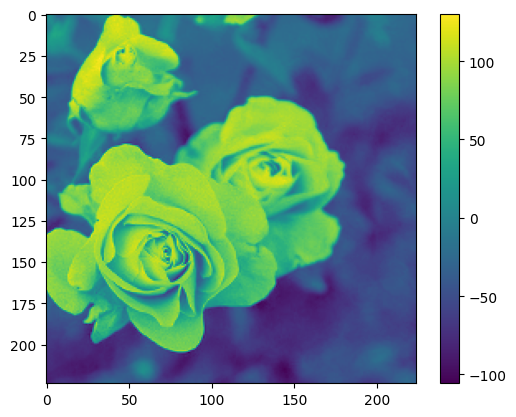

In [4]:
data_next = de_train.create_dict_iterator(output_numpy=True).__next__()
print('通道数/图像长/宽：', data_next['image'][0,...].shape)
print('一张图像的标签样式：', data_next['label'][0])  # 一共5类，用0-4的数字表达类别。

plt.figure()
plt.imshow(data_next['image'][0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()

## 5、模型构建

###### 残差块（Residual Block）

将前面若干层的输出跳过中间层作为后几层的输入部分，也就是说后面特征层会有前几层的部分线性贡献。此种设计是为了克服随着网络层数加深而产生的学习效率变低和准确率无法有效提升的问题。

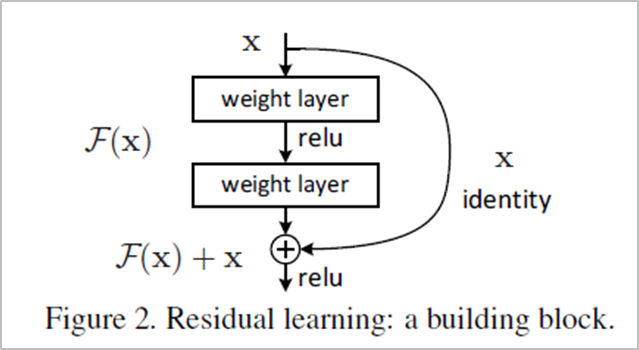

如果维度相同：

$$y=F(x,W_{i})+x$$

$$F=W_{2}\delta (W,x)$$

如果维度不同，则采用：
$$y=F(x,W_{i})+W_{s}x$$

##### 瓶颈（BottleNeck）模块：

瓶颈（BottleNeck）模块，思路和Inception一样，通过1x1 conv来巧妙地缩减或扩张feature map维度从而使3x3 conv的filters数目不受外界即上一层输入的影响，自然它的输出也不会影响到下一层module。

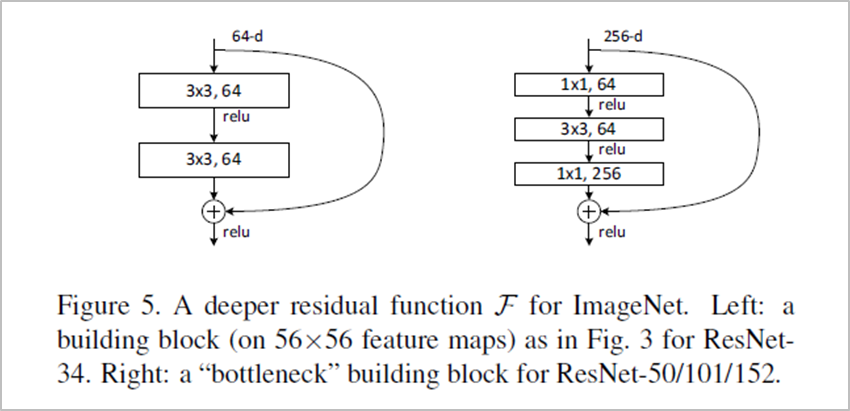

##### ResNet50模型构建

ResNet50有两个基本的块，分别名为Conv Block和Identity Block，其中Conv Block输入和输出的维度是不一样的，所以不能连续串联，它的作用是改变网络的维度；Identity Block输入维度和输出维度相同，可以串联，用于加深网络。

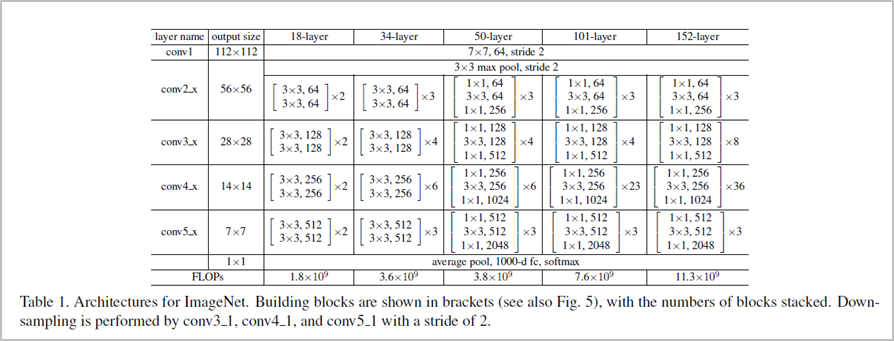

In [5]:
"""ResNet."""

# 定义权重初始化函数
def _weight_variable(shape, factor=0.01):
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)

# 定义3X3卷积函数
def _conv3x3(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 3, 3)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=3, stride=stride, padding=0, pad_mode='same', weight_init=weight)

# 定义1X1卷积层函数
def _conv1x1(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 1, 1)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=1, stride=stride, padding=0, pad_mode='same', weight_init=weight)

# 定义7X7卷积层函数
def _conv7x7(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 7, 7)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight)

# 定义Batch Norm层函数
def _bn(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)

# 定义最后一层的Batch Norm函数
def _bn_last(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1)

# 定义全连接层函数
def _fc(in_channel, out_channel):
    weight_shape = (out_channel, in_channel)
    weight = _weight_variable(weight_shape)
    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)

# 构建残差模块
class ResidualBlock(nn.Cell):
    expansion = 4  # conv2_x--conv5_x中，前两层的卷积核的个数是第三层（也就是输出通道）的4分之一。

    def __init__(self, in_channel, out_channel, stride=1):
        super(ResidualBlock, self).__init__()

        # 前两层的卷积核个数等于输出通道的四分之一
        channel = out_channel // self.expansion  
        
        # 第一层卷积
        self.conv1 = _conv1x1(in_channel, channel, stride=1)
        self.bn1 = _bn(channel)
        # 第二层卷积
        self.conv2 = _conv3x3(channel, channel, stride=stride)
        self.bn2 = _bn(channel)
        
        # 第三层卷积，其中卷积核个数等于输出通道
        self.conv3 = _conv1x1(channel, out_channel, stride=1)
        self.bn3 = _bn_last(out_channel)
        
        # Relu激活层
        self.relu = nn.ReLU()

        self.down_sample = False
        
        # 当步长不为1、或输出通道不等于输入通道时，进行图像下采样，用来调整通道数
        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None
        # 用1X1卷积调整通道数
        if self.down_sample:
            self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel, stride), # 1X1卷积
                                                        _bn(out_channel)])  # Batch Norm
        # 加法算子
        self.add = ops.Add()

    # 构建残差块    
    def construct(self, x): 
        # 输入
        identity = x
        
        # 第一层卷积 1X1
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # 第二层卷积 3X3
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        # 第三层卷积 1X1
        out = self.conv3(out)
        out = self.bn3(out)

        # 改变网络的维度
        if self.down_sample:
            identity = self.down_sample_layer(identity)
        
        # 加上残差
        out = self.add(out, identity)
        # Relu激活
        out = self.relu(out)

        return out

# 构建残差网络
class ResNet(nn.Cell):
    # 输入参数为：残差块，残差块重复数，输入通道，输出通道，步长，图像类别数
    def __init__(self, block, layer_nums, in_channels, out_channels, strides, num_classes):
        super(ResNet, self).__init__()

        # 报错信息，不用管
        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")

        # 第一层卷积，卷积核7X7，输入通道3，输出通道64，步长2
        self.conv1 = _conv7x7(3, 64, stride=2)
        self.bn1 = _bn(64)
        self.relu = ops.ReLU()
        
        # 3X3池化层，步长2
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        # conv2_x残差块
        self.layer1 = self._make_layer(block,
                                       layer_nums[0],
                                       in_channel=in_channels[0],
                                       out_channel=out_channels[0],
                                       stride=strides[0])
        # conv3_x残差块
        self.layer2 = self._make_layer(block,
                                       layer_nums[1],
                                       in_channel=in_channels[1],
                                       out_channel=out_channels[1],
                                       stride=strides[1])
        # conv4_x残差块
        self.layer3 = self._make_layer(block,
                                       layer_nums[2],
                                       in_channel=in_channels[2],
                                       out_channel=out_channels[2],
                                       stride=strides[2])
        # conv5_x残差块
        self.layer4 = self._make_layer(block,
                                       layer_nums[3],
                                       in_channel=in_channels[3],
                                       out_channel=out_channels[3],
                                       stride=strides[3])
        # 均值算子
        self.mean = ops.ReduceMean(keep_dims=True)
        # Flatten层
        self.flatten = nn.Flatten()
        # 输出层
        self.end_point = _fc(out_channels[3], num_classes)

    # 输入参数为：残差块，残差块重复数，输入通道，输出通道，步长
    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        # 搭建convn_x的残差块
        
        layers = []
        
        resnet_block = block(in_channel, out_channel, stride=stride)
        layers.append(resnet_block)

        for _ in range(1, layer_num):
            resnet_block = block(out_channel, out_channel, stride=1)
            layers.append(resnet_block)

        return nn.SequentialCell(layers)
    
    # 构建 ResNet网络
    def construct(self, x): 
        x = self.conv1(x)  # 第一层卷积7X7，步长为2
        x = self.bn1(x)    # 第一层的Batch Norm
        x = self.relu(x)   # Rule激活层
        c1 = self.maxpool(x)  # 最大池化3X3，步长为2

        c2 = self.layer1(c1) # conv2_x残差块
        c3 = self.layer2(c2) # conv3_x残差块
        c4 = self.layer3(c3) # conv4_x残差块
        c5 = self.layer4(c4) # conv5_x残差块

        out = self.mean(c5, (2, 3)) # 平均池化层
        out = self.flatten(out)  # Flatten层
        out = self.end_point(out)  # 输出层

        return out

# 构建ResNet50 网络
def resnet50(class_num=10):
    return ResNet(ResidualBlock,    # 残差块
                  [3, 4, 6, 3],  # 残差块数量
                  [64, 256, 512, 1024],  # 输入通道
                  [256, 512, 1024, 2048], # 输出通道
                  [1, 2, 2, 2],  # 步长
                  class_num) # 输出类别数

# 构建ResNet101 网络
def resnet101(class_num=1001):
    return ResNet(ResidualBlock,
                  [3, 4, 23, 3],
                  [64, 256, 512, 1024],
                  [256, 512, 1024, 2048],
                  [1, 2, 2, 2],
                  class_num)

## 6、模型训练

###### 定义学习率函数

设定动态学习率，加速模型收敛。

In [6]:
def get_lr(global_step, total_epochs, steps_per_epoch, lr_init=0.01, lr_max=0.1, warmup_epochs=5):
    
    lr_each_step = []
    total_steps = steps_per_epoch * total_epochs
    warmup_steps = steps_per_epoch * warmup_epochs
    if warmup_steps != 0:
        inc_each_step = (float(lr_max) - float(lr_init)) / float(warmup_steps)
    else:
        inc_each_step = 0
    for i in range(int(total_steps)):
        if i < warmup_steps:
            lr = float(lr_init) + inc_each_step * float(i)
        else:
            base = ( 1.0 - (float(i) - float(warmup_steps)) / (float(total_steps) - float(warmup_steps)) )
            lr = float(lr_max) * base * base
            if lr < 0.0:
                lr = 0.0
        lr_each_step.append(lr)

    current_step = global_step
    lr_each_step = np.array(lr_each_step).astype(np.float32)
    learning_rate = lr_each_step[current_step:]

    return learning_rate

###### 开始训练

完成数据预处理、网络定义、损失函数和优化器定义之后，开始模型训练。模型训练包含2层迭代，数据集的多轮迭代epoch和一轮数据集内按分组从数据集中抽取数据，输入网络计算得到损失函数，然后通过优化器计算和更新训练参数的梯度。

In [7]:
import mindspore as ms
# 构建ResNet50网络，输出类别数为5，对应5种花的类别
net = resnet50(class_num=cfg.num_class)

# 设置Softmax交叉熵损失函数
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")

# 设置动态学习率
train_step_size = de_train.get_dataset_size()
lr = Tensor(get_lr(global_step=0, total_epochs=cfg.epoch_size, steps_per_epoch=train_step_size))

# 设置动量优化器
opt = Momentum(net.trainable_params(), lr, momentum=0.9, weight_decay=1e-4, loss_scale=cfg.loss_scale_num)

# 损失值平滑，解决训练过程中梯度过小的问题
loss_scale = FixedLossScaleManager(cfg.loss_scale_num, False)

# 模型编译，输入网络结构，损失函数，优化器，损失值平滑，以及模型评估标准
model = Model(net, loss_fn=loss, optimizer=opt, loss_scale_manager=loss_scale, metrics={'acc'})

# 定义用于训练的train_loop函数。
def train_loop(model, dataset, loss_fn, optimizer):
    # 定义正向计算函数
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss

    # 定义微分函数，使用mindspore.value_and_grad获得微分函数grad_fn,输出loss和梯度。
    # 由于是对模型参数求导,grad_position 配置为None，传入可训练参数。
    grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters)

    # 定义 one-step training函数
    def train_step(data, label):
        loss, grads = grad_fn(data, label)
        optimizer(grads)
        return loss

    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

# 定义用于测试的test_loop函数。
def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

for t in range(cfg.epoch_size):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(net, de_train, loss, opt)
    #ms.save_checkpoint(network, "./save_direct.ckpt")
    test_loop(net, de_test, loss)
print("Done!")

Epoch 1
-------------------------------
loss: 1.654428  [  0/113]
loss: 1.387678  [100/113]
Test: 
 Accuracy: 55.8%, Avg loss: 1.334131 

Epoch 2
-------------------------------
loss: 1.410290  [  0/113]
loss: 1.354808  [100/113]
Test: 
 Accuracy: 59.6%, Avg loss: 1.177230 

Epoch 3
-------------------------------
loss: 1.273952  [  0/113]
loss: 1.283408  [100/113]
Test: 
 Accuracy: 63.5%, Avg loss: 1.099474 

Done!


## 7、模型预测

In [8]:
# 模型预测，从测试集中取10个样本进行测试，输出预测结果和真实标签
class_names = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'}
for i in range(10):
    test_ = de_test.create_dict_iterator().__next__()
    test = Tensor(test_['image'], mindspore.float32)
    # 模型预测
    predictions = model.predict(test)
    predictions = predictions.asnumpy()
    true_label = test_['label'].asnumpy()
    # 显示预测结果
    p_np = predictions[0, :]
    pre_label = np.argmax(p_np)
    print('第' + str(i) + '个sample预测结果：', class_names[pre_label], '   真实结果：', class_names[true_label[0]]) 

第0个sample预测结果： sunflowers    真实结果： daisy
第1个sample预测结果： tulips    真实结果： roses
第2个sample预测结果： dandelion    真实结果： tulips
第3个sample预测结果： sunflowers    真实结果： sunflowers
第4个sample预测结果： dandelion    真实结果： daisy
第5个sample预测结果： daisy    真实结果： daisy
第6个sample预测结果： sunflowers    真实结果： sunflowers
第7个sample预测结果： sunflowers    真实结果： dandelion
第8个sample预测结果： daisy    真实结果： daisy
第9个sample预测结果： tulips    真实结果： tulips
